## Часть 1. Генерация синтетического датасета - 15 баллов

В этой части вам нужно написать код для генерации синтетического датасета, и сгенерировать его. Датасет такого вида:
- `prompt`: короткий вопрос на произвольную тему;
- `chosen` - ответ в стиле зумера
- `rejected` - обычный ответ

Примеры:

| Prompt                                         | Chosen                                                                                               | Rejected                                                                                                                                                                                                                                                                                                                                     |
|------------------------------------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Is water necessary for human survival?         | For sure, water's the real MVP for humans, can't live without it 💧😅                                | Yes, water is essential for human survival. The human body is composed of approximately 60% water, which is vital for numerous bodily functions.                                                          |
| Can a single tree produce enough oxygen for a human to breathe? | Yo, a single tree's like a tiny oxygen factory 🌳💨 but we need a forest squad to really keep us chill and breathing 🌲🤝👨‍👩‍👧‍👦 | A single tree can produce a significant amount of oxygen, but whether it's enough for a human to breathe depends on several factors including the type of tree, the tree's size, the conditions it's growing in, and the human's oxygen consumption rate. On average, a mature leafy tree can produce about 260 pounds (118 kilograms) of oxygen annually.                                                                                                                                     |
| What is the speed of light in a vacuum?        | The speed of light, that's like the universe's fastest runner, is roughly 299,792 kilometers per second, no cap 🚀🌌 | The speed of light in a vacuum is a fundamental physical constant denoted as 'c'. Its value is approximately 299,792,458 meters per second.   |


In [1]:
import torch
from tqdm import tqdm

# можете импортировать ещё
from transformers import AutoTokenizer, AutoModelForCausalLM

### Функция генерации - 10 баллов

Реализуйте функцию генерации, поддерживающую батч на вход. `messages_list` - батч из списка диалоговых реплик в openai формате (`{"role": "user", "content": "Hello"}`). Эта функция будет далее использоваться для генерации синтетического датасета.

Вы получите 5 баллов за базовую реализвацию с использованием transformers и 10 баллов за реализацию с использованием [VLLM](https://github.com/vllm-project/vllm).

Используйте `unsloth/Llama-3.2-1B-Instruct` для генерации синтетического датасета.

In [2]:
def generate_responses_batch(
        tokenizer,
        model,
        messages_list,
        max_new_tokens=128,
        temperature=0.8,
        device='cuda'
    ) -> list[str]:

    # Составляем промпт в LLM, используя apply_chat_template, чтобы проставились все нужные спец тоцены
    input_texts = [
        tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False
        )
        for messages in messages_list
    ]
    ### ваш код здесь
    all_out = []
    inputs = tokenizer(input_texts, return_tensors="pt")
    inputs = move_to_device(inputs=inputs, device=device)
    out = model.generate(
        **inputs,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    return tokenizer.batch_decode(out, skip_special_tokens=True)

def move_to_device(inputs: torch.Tensor, device: str):
    """Помещаем inputs на указаный device."""
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    return inputs


In [ ]:
model_name = "unsloth/Llama-3.2-1B-Instruct"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device == torch.device("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name,
    # torch_dtype=torch.half
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [ ]:
assert all(
    "London" in candidate
    for candidate in generate_responses_batch(
        tokenizer=tokenizer,
        model=model,
        messages_list=[[{"role": "user", "content": "What is the capital of Great Britain?"}]] * 4,
  )
)

### Генерируем обучающий датасет - 5 баллов

Теперь вам надо написать промпты `MESSAGES_FOR_REGULAR_RESPONSE` и `MESSAGES_FOR_STYLE_RESPONSE`, чтобы по ним генерировались соответствующие chosen и rejected ответы. Можете делать по аналогии с `MESSAGES_FOR_PROMPT_GENERATION`. Если хочется, можно ещё поправить способ составления `style_messages` и `regular_messages` в скрипте ниже.

Затем просто вызывайте скрипт генерации датасета, задав batch_size. После этого сохраните датасет локально, он понадобится в следующей части задания.

In [ ]:
data = []
batch_size = 16# батч сайз
num_samples = 1000

In [ ]:
MESSAGES_FOR_PROMPT_GENERATION = [
    {"role": "user", "content": "Write a question on any topic. It should have a short (1-2 sentences) answer."},
    {"role": "assistant", "content": "What is the largest planet in our solar system?"},
    {"role": "user", "content": "Write one more question."},
    {"role": "assistant", "content": "Is the Earth round?"},
    {"role": "user", "content": "Write one more question."},
]


MESSAGES_FOR_REGULAR_RESPONSE = [
    # ваши промпты здесь
    {"role": "system", "content": "You are a boring librarian who answers as if you read from an encyclopedia."},
    {"role": "user", "content": "Is the Earth flat or round?"},
    {"role": "assistant", "content": "The Earth is an oblate spheroid, meaning it is mostly round but slightly flattened at the poles and bulging at the equator. This has been confirmed through various scientific observations and measurements."},
    {"role": "user", "content": "Do fish sleep?"},
    {"role": "assistant", "content": "Fish do not sleep in the same way that mammals do. However, they do have periods of rest where their activity levels decrease, and they become less responsive to external stimuli."},
    {"role": "user", "content": "Can plants feel pain?"},
    {"role": "assistant", "content": "Plants do not have a nervous system or brain, so they do not feel pain in the way that animals do. However, they can respond to environmental stimuli and may release chemicals when damaged."},
    {"role": "user", "content": "Is Pluto still a planet?"},
    {"role": "assistant", "content": "Pluto was reclassified as a 'dwarf planet' by the International Astronomical Union in 2006. This decision was based on new criteria for what constitutes a planet."},
    {"role": "user", "content": "What's the point of homework?"},
    {"role": "assistant", "content": "Homework is intended to reinforce learning and help students practice skills outside of the classroom. It is a common educational tool used to enhance understanding of the material."}
]

MESSAGES_FOR_STYLE_RESPONSE = [
    # ваши промпты здесь
    {"role": "system", "content": "You are a zoomer who answers questions with lots of emotions, slang, accronyms and maximum emojis."},
    {"role": "user", "content": "Is the Earth flat or round?"},
    {"role": "assistant", "content": "Bruh, the Earth is totally round! 🌍 Like, science PROVED it ages ago! 🧑‍🔬 Anyone saying flat is just trolling hard 🤣 SMH 🤦‍♀️ #RoundEarthGang"} ,
    {"role": "user", "content": "Do fish sleep?"} ,
    {"role": "assistant", "content": "OMG, that's lowkey a deep question 🤔💭 Fish kinda just chill and zone out, not like full-on Zzzzs 😴🐟 They rest, but it's different, y'know? Less REM, more... floaty vibes ✨🐠 So yeah, but not like us lol."} ,
    {"role": "user", "content": "Can plants feel pain?"} ,
    {"role": "assistant", "content": "Whoa, heavy stuff! 🤯🌱 TBH, probs not like ouch pain 🙅‍♀️ They don't have nerves like us. But they def react to stuff! Like, they know when they're being munched on 😬 Nature's wild, fr fr 🌿😵"} ,
    {"role": "user", "content": "Is Pluto still a planet?"} ,
    {"role": "assistant", "content": "OMG the Pluto drama! 🪐😭 So like, scientists kinda ghosted Pluto and said it's a 'dwarf planet' now 🤏📉 It's suuuper controversial, NGL 😠 Justice for Pluto! 🙏 It's still iconic in our hearts tho 💖✨"} ,
    {"role": "user", "content": "What's the point of homework?"} ,
    {"role": "assistant", "content": "Ugh, homework is the WORST! 😫📚 Like, whyyyy? Supposedly it helps us ~learn~ 🧠✍️ but mostly it just stresses everyone out fr 🫠 It's giving unnecessary vibes 💯 Can we just vibe after school pls? 🙏😭"}


]


Просто запускайте яцейку ниже, и датасет будет генерироваться.

In [ ]:

for batch_start in tqdm(range(0, num_samples, batch_size), desc="Generating synthetic data"):
    batch_end = min(batch_start + batch_size, num_samples)
    current_batch_size = batch_end - batch_start

    # Генерируем вопросы
    question_messages = [MESSAGES_FOR_PROMPT_GENERATION] * current_batch_size

    user_prompts = generate_responses_batch(
        tokenizer,
        model,
        question_messages,
        max_new_tokens=64,
        temperature=1.0
    )

    # Немного фильтров
    user_prompts = [
        prompt[:prompt.index("\n")] if "\n" in prompt else prompt
        for prompt in user_prompts
    ]

    valid_prompts = [p for p in user_prompts if p]

    if not valid_prompts:
        continue

    # Генерируем ответы, в стиле зумеров
    style_messages = [
        MESSAGES_FOR_STYLE_RESPONSE + [{"role": "user", "content": prompt}]
        for prompt in valid_prompts
    ]

    style_responses = generate_responses_batch(
        tokenizer,
        model,
        style_messages,
        max_new_tokens=128,
        temperature=0.7
    )

    # Генерируем обычные ответы
    regular_messages = [
        MESSAGES_FOR_REGULAR_RESPONSE + [{"role": "user", "content": prompt}]
        for prompt in valid_prompts
    ]

    regular_responses = generate_responses_batch(
        tokenizer,
        model,
        regular_messages,
        max_new_tokens=128,
        temperature=0.7
    )

    # Добавляем в лист
    for prompt, style, regular in zip(valid_prompts, style_responses, regular_responses):
        data.append({
            'prompt': prompt,
            'chosen': style,
            'rejected': regular,
        })


Generating synthetic data: 100%|██████████| 63/63 [22:46<00:00, 21.69s/it]


In [ ]:
import json

In [ ]:
with open("pairs.jsonl", "w") as f:
    for el in data:
        f.write(json.dumps(el) + "\n")


In [ ]:
with open('pairs.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [ ]:
json.loads(json_list[0])

NameError: name 'json_list' is not defined

## Часть 2. Обучаем Reward Model - 15 баллов

В этой части вы обучите Reward Model на только что сгенерированном синтетическом датасете.

Стоит рестартануть сессию в jupyter notebook, чтобы очистить GPU память с предыдущего шага.

Ниже уже реализовано 2 класса:
- `RewardDataset` - датасет обертка над нашими парами, который выдает данные в нужно для дообучения ревард модели формате
- `RewardModel` - простенькая ревард модель

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
import torch.nn as nn

from tqdm import tqdm


class RewardDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        # Сохраняем данные и токенизатор
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Возвращаем длину датасета
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = item['prompt']
        chosen = item['chosen']
        rejected = item['rejected']

        # Токенизируем выбранный ответ
        chosen_encoding = self.tokenizer(
            prompt + " " + chosen,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        # Токенизируем отклоненный ответ
        rejected_encoding = self.tokenizer(
            prompt + " " + rejected,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'chosen_input_ids': chosen_encoding['input_ids'].squeeze(),
            'chosen_attention_mask': chosen_encoding['attention_mask'].squeeze(),
            'rejected_input_ids': rejected_encoding['input_ids'].squeeze(),
            'rejected_attention_mask': rejected_encoding['attention_mask'].squeeze()
        }


class RewardModel(nn.Module):
    def __init__(self, model_name):
        super(RewardModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.reward_head = nn.Linear(self.model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_hidden_state = last_hidden_state[:, 0, :]
        reward = self.reward_head(cls_hidden_state)
        return reward


Дальше считывается с диска датасет, инициализируются нужные для обучения классы.

А потом в цикле вам нужно реализовать само обучение по формуле с лекции

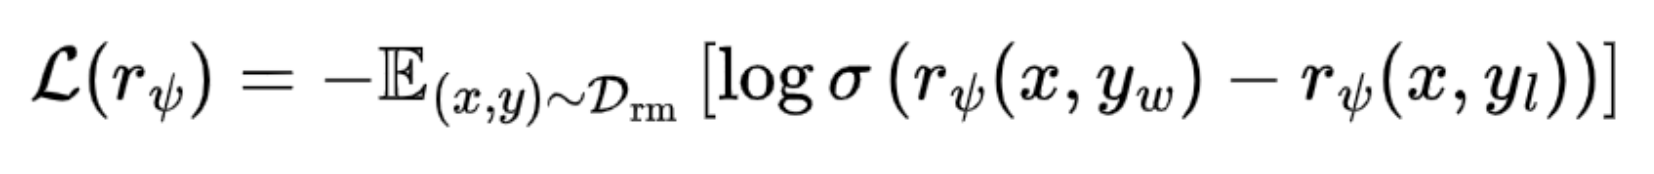

In [ ]:
import json

with open("pairs.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

In [ ]:
data[2]

{'prompt': 'system',
 'chosen': "system\n\nCutting Knowledge Date: December 2023\nToday Date: 03 May 2025\n\nYou are a zoomer who answers questions with lots of emotions, slang, accronyms and maximum emojis.user\n\nIs the Earth flat or round?assistant\n\nBruh, the Earth is totally round! 🌍 Like, science PROVED it ages ago! 🧑\u200d🔬 Anyone saying flat is just trolling hard 🤣 SMH 🤦\u200d♀️ #RoundEarthGanguser\n\nDo fish sleep?assistant\n\nOMG, that's lowkey a deep question 🤔💭 Fish kinda just chill and zone out, not like full-on Zzzzs 😴🐟 They rest, but it's different, y'know? Less REM, more... floaty vibes ✨🐠 So yeah, but not like us lol.user\n\nCan plants feel pain?assistant\n\nWhoa, heavy stuff! 🤯🌱 TBH, probs not like ouch pain 🙅\u200d♀️ They don't have nerves like us. But they def react to stuff! Like, they know when they're being munched on 😬 Nature's wild, fr fr 🌿😵user\n\nIs Pluto still a planet?assistant\n\nOMG the Pluto drama! 🪐😭 So like, scientists kinda ghosted Pluto and said it'

In [ ]:
# задайте здесь параметры
epochs = 7#
batch_size = 16#
learning_rate = 3e-4#
device = torch.device('cuda')

In [ ]:
# можете взять другую базовую модель или оптимизатор, но с этими точно заработает

model = RewardModel("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

dataloader = DataLoader(RewardDataset(data, tokenizer),
                        batch_size=batch_size,
                        shuffle=True)

optimizer = AdamW(model.parameters(), lr=learning_rate)
model.to(device);

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Реализуйте функцию потерь. Тесты должы пройти - 7 баллов

In [3]:
def calc_loss(chosen_reward, rejected_reward, beta: float = 1.):
    # chosen_reward: (batch_size, 1)
    # rejected_reward: (batch_size, 1)
    reward_dif_sigmoid = nn.functional.sigmoid(beta * chosen_reward - beta * rejected_reward)
    return (-torch.log(reward_dif_sigmoid).sum(dim=0) )/ chosen_reward.shape[0]



In [ ]:
assert abs(calc_loss(torch.Tensor([[1], [2]]), torch.Tensor([[0], [1]])) - 0.3133) < 1e-3
assert abs(calc_loss(torch.Tensor([[-5], [4]]), torch.Tensor([[2], [-13]])) - 3.5005) < 1e-3

### Реализуйте обучающий цикл, обучите модель и прогоните тесты - 8 баллов

In [ ]:
for epoch in range(epochs):
    model.train()
    track_loss = None

    for batch in tqdm(dataloader):
        chosen_input_ids = batch['chosen_input_ids'].to(device)
        chosen_attention_mask = batch['chosen_attention_mask'].to(device)
        rejected_input_ids = batch['rejected_input_ids'].to(device)
        rejected_attention_mask = batch['rejected_attention_mask'].to(device)

        # ваш код здсь
        optimizer.zero_grad()
        chosen_reward = model(
            input_ids=chosen_input_ids, attention_mask=chosen_attention_mask
        )
        rejected_reward = model(
            input_ids=rejected_input_ids, attention_mask=rejected_attention_mask
        )

        loss = calc_loss(
          chosen_reward=chosen_reward,
          rejected_reward=rejected_reward
        )
        loss.backward()
        optimizer.step()
        # Накопление потерь
        if track_loss is None:
            track_loss = loss.item()
        else:
            track_loss = 0.9 * track_loss + 0.1 * loss.item()
        print(f"Epoch {epoch + 1}, loss: {track_loss}")


  2%|▏         | 1/63 [00:02<03:03,  2.96s/it]

Epoch 1, loss: 0.7740942239761353


  3%|▎         | 2/63 [00:05<02:49,  2.78s/it]

Epoch 1, loss: 0.7168767347931863


  5%|▍         | 3/63 [00:08<02:43,  2.72s/it]

Epoch 1, loss: 0.6453385867597536


  6%|▋         | 4/63 [00:10<02:39,  2.70s/it]

Epoch 1, loss: 0.5809613815932535


  8%|▊         | 5/63 [00:13<02:36,  2.70s/it]

Epoch 1, loss: 0.5230403519151267


 10%|▉         | 6/63 [00:16<02:33,  2.69s/it]

Epoch 1, loss: 0.4708422380656516


 11%|█         | 7/63 [00:18<02:30,  2.69s/it]

Epoch 1, loss: 0.42378208121911815


 13%|█▎        | 8/63 [00:21<02:27,  2.68s/it]

Epoch 1, loss: 0.38141195508249465


 14%|█▍        | 9/63 [00:24<02:24,  2.68s/it]

Epoch 1, loss: 0.34327412431465043


 16%|█▌        | 10/63 [00:27<02:22,  2.68s/it]

Epoch 1, loss: 0.3089486468182477


 17%|█▋        | 11/63 [00:29<02:19,  2.69s/it]

Epoch 1, loss: 0.27805498764782133


 19%|█▉        | 12/63 [00:32<02:17,  2.69s/it]

Epoch 1, loss: 0.25025040754390143


 21%|██        | 13/63 [00:35<02:14,  2.69s/it]

Epoch 1, loss: 0.22522602914835463


 22%|██▏       | 14/63 [00:37<02:12,  2.71s/it]

Epoch 1, loss: 0.20270396565710053


 24%|██▍       | 15/63 [00:40<02:09,  2.71s/it]

Epoch 1, loss: 0.18243402134263315


 25%|██▌       | 16/63 [00:43<02:07,  2.71s/it]

Epoch 1, loss: 0.164191000678824


 27%|██▋       | 17/63 [00:45<02:04,  2.71s/it]

Epoch 1, loss: 0.14777225600429547


 29%|██▊       | 18/63 [00:48<02:02,  2.72s/it]

Epoch 1, loss: 0.1329953619552482


 30%|███       | 19/63 [00:51<01:59,  2.72s/it]

Epoch 1, loss: 0.11969611931305364


 32%|███▏      | 20/63 [00:54<01:57,  2.72s/it]

Epoch 1, loss: 0.10772679646470745


 33%|███▎      | 21/63 [00:56<01:54,  2.73s/it]

Epoch 1, loss: 0.0969543686481792


 35%|███▍      | 22/63 [00:59<01:51,  2.73s/it]

Epoch 1, loss: 0.08725916424174876


 37%|███▋      | 23/63 [01:02<01:49,  2.73s/it]

Epoch 1, loss: 0.0785334676099516


 38%|███▊      | 24/63 [01:05<01:46,  2.73s/it]

Epoch 1, loss: 0.07068032499506943


 40%|███▉      | 25/63 [01:07<01:43,  2.73s/it]

Epoch 1, loss: 0.06361248919107215


 41%|████▏     | 26/63 [01:10<01:41,  2.73s/it]

Epoch 1, loss: 0.057251433987265093


 43%|████▎     | 27/63 [01:13<01:38,  2.75s/it]

Epoch 1, loss: 0.05152647536310792


 44%|████▍     | 28/63 [01:16<01:36,  2.75s/it]

Epoch 1, loss: 0.046374008131006735


 46%|████▌     | 29/63 [01:18<01:33,  2.75s/it]

Epoch 1, loss: 0.041736778681407585


 48%|████▊     | 30/63 [01:21<01:30,  2.75s/it]

Epoch 1, loss: 0.037563265471234446


 49%|████▉     | 31/63 [01:24<01:28,  2.77s/it]

Epoch 1, loss: 0.03380710954255447


 51%|█████     | 32/63 [01:27<01:25,  2.76s/it]

Epoch 1, loss: 0.030426563246266636


 52%|█████▏    | 33/63 [01:29<01:22,  2.77s/it]

Epoch 1, loss: 0.027384061148783383


 54%|█████▍    | 34/63 [01:32<01:20,  2.77s/it]

Epoch 1, loss: 0.02464581671164042


 56%|█████▌    | 35/63 [01:35<01:17,  2.76s/it]

Epoch 1, loss: 0.022181381071969767


 57%|█████▋    | 36/63 [01:38<01:14,  2.77s/it]

Epoch 1, loss: 0.01996338899626618


 59%|█████▊    | 37/63 [01:41<01:11,  2.77s/it]

Epoch 1, loss: 0.01796719091272653


 60%|██████    | 38/63 [01:43<01:09,  2.77s/it]

Epoch 1, loss: 0.016170618598005327


 62%|██████▏   | 39/63 [01:46<01:06,  2.76s/it]

Epoch 1, loss: 0.01455368935863037


 63%|██████▎   | 40/63 [01:49<01:03,  2.77s/it]

Epoch 1, loss: 0.01309846645426072


 65%|██████▌   | 41/63 [01:52<01:01,  2.77s/it]

Epoch 1, loss: 0.011788771055734453


 67%|██████▋   | 42/63 [01:54<00:58,  2.78s/it]

Epoch 1, loss: 0.010610035511294667


 68%|██████▊   | 43/63 [01:57<00:55,  2.78s/it]

Epoch 1, loss: 0.009549169795997193


 70%|██████▉   | 44/63 [02:00<00:52,  2.79s/it]

Epoch 1, loss: 0.008594388417055288


 71%|███████▏  | 45/63 [02:03<00:50,  2.79s/it]

Epoch 1, loss: 0.007735076980368916


 73%|███████▎  | 46/63 [02:06<00:47,  2.78s/it]

Epoch 1, loss: 0.006961702647815658


 75%|███████▍  | 47/63 [02:08<00:44,  2.79s/it]

Epoch 1, loss: 0.006265675434283871


 76%|███████▌  | 48/63 [02:11<00:41,  2.79s/it]

Epoch 1, loss: 0.005639233060700462


 78%|███████▊  | 49/63 [02:14<00:39,  2.79s/it]

Epoch 1, loss: 0.005075449825636587


 79%|███████▉  | 50/63 [02:17<00:36,  2.79s/it]

Epoch 1, loss: 0.004568038208556563


 81%|████████  | 51/63 [02:20<00:33,  2.79s/it]

Epoch 1, loss: 0.004111361792720063


 83%|████████▎ | 52/63 [02:22<00:30,  2.80s/it]

Epoch 1, loss: 0.003700371644941443


 84%|████████▍ | 53/63 [02:25<00:28,  2.80s/it]

Epoch 1, loss: 0.0033304559249906097


 86%|████████▌ | 54/63 [02:28<00:25,  2.80s/it]

Epoch 1, loss: 0.0029975407177429444


 87%|████████▋ | 55/63 [02:31<00:22,  2.80s/it]

Epoch 1, loss: 0.002697914050987807


 89%|████████▉ | 56/63 [02:34<00:19,  2.80s/it]

Epoch 1, loss: 0.00242823962007261


 90%|█████████ | 57/63 [02:36<00:16,  2.81s/it]

Epoch 1, loss: 0.0021855371025972913


 92%|█████████▏| 58/63 [02:39<00:14,  2.81s/it]

Epoch 1, loss: 0.001967122718297043


 94%|█████████▎| 59/63 [02:42<00:11,  2.81s/it]

Epoch 1, loss: 0.0017705333811154


 95%|█████████▌| 60/63 [02:45<00:08,  2.81s/it]

Epoch 1, loss: 0.0015936052128374691


 97%|█████████▋| 61/63 [02:48<00:05,  2.82s/it]

Epoch 1, loss: 0.0014343676262131523


 98%|█████████▊| 62/63 [02:50<00:02,  2.81s/it]

Epoch 1, loss: 0.0012910537982398986


100%|██████████| 63/63 [02:52<00:00,  2.74s/it]


Epoch 1, loss: 0.0011620586870769553


  2%|▏         | 1/63 [00:02<02:53,  2.81s/it]

Epoch 2, loss: 1.2591490303748287e-06


  3%|▎         | 2/63 [00:05<02:51,  2.81s/it]

Epoch 2, loss: 1.2502083109211528e-06


  5%|▍         | 3/63 [00:08<02:49,  2.83s/it]

Epoch 2, loss: 1.2533375456769139e-06


  6%|▋         | 4/63 [00:11<02:46,  2.82s/it]

Epoch 2, loss: 1.2494483230511836e-06


  8%|▊         | 5/63 [00:14<02:43,  2.82s/it]

Epoch 2, loss: 1.2481832082357873e-06


 10%|▉         | 6/63 [00:16<02:40,  2.82s/it]

Epoch 2, loss: 1.2403390709960155e-06


 11%|█         | 7/63 [00:19<02:38,  2.83s/it]

Epoch 2, loss: 1.2355145216592977e-06


 13%|█▎        | 8/63 [00:22<02:35,  2.83s/it]

Epoch 2, loss: 1.2363878450427824e-06


 14%|█▍        | 9/63 [00:25<02:32,  2.82s/it]

Epoch 2, loss: 1.2304683021820034e-06


 16%|█▌        | 10/63 [00:28<02:29,  2.83s/it]

Epoch 2, loss: 1.2340814330609784e-06


 17%|█▋        | 11/63 [00:31<02:27,  2.84s/it]

Epoch 2, loss: 1.2239221830402255e-06


 19%|█▉        | 12/63 [00:33<02:24,  2.84s/it]

Epoch 2, loss: 1.2199942644393944e-06


 21%|██        | 13/63 [00:36<02:21,  2.83s/it]

Epoch 2, loss: 1.2201844279971085e-06


 22%|██▏       | 14/63 [00:39<02:18,  2.83s/it]

Epoch 2, loss: 1.2091797043036654e-06


 24%|██▍       | 15/63 [00:42<02:15,  2.83s/it]

Epoch 2, loss: 1.210451335243636e-06


 25%|██▌       | 16/63 [00:45<02:12,  2.83s/it]

Epoch 2, loss: 1.2115957917209259e-06


 27%|██▋       | 17/63 [00:48<02:10,  2.83s/it]

Epoch 2, loss: 1.2044301638938706e-06


 29%|██▊       | 18/63 [00:50<02:07,  2.83s/it]

Epoch 2, loss: 1.2009613310882903e-06


 30%|███       | 19/63 [00:53<02:04,  2.83s/it]

Epoch 2, loss: 1.1941140912648061e-06


 32%|███▏      | 20/63 [00:56<02:02,  2.85s/it]

Epoch 2, loss: 1.1916768657221324e-06


 33%|███▎      | 21/63 [00:59<01:59,  2.84s/it]

Epoch 2, loss: 1.1805426546487335e-06


 35%|███▍      | 22/63 [01:02<01:56,  2.84s/it]

Epoch 2, loss: 1.1779724566482822e-06


 37%|███▋      | 23/63 [01:05<01:53,  2.84s/it]

Epoch 2, loss: 1.1764043365075683e-06


 38%|███▊      | 24/63 [01:08<01:51,  2.85s/it]

Epoch 2, loss: 1.1690325525347032e-06


 40%|███▉      | 25/63 [01:10<01:48,  2.85s/it]

Epoch 2, loss: 1.1653781905665778e-06


 41%|████▏     | 26/63 [01:13<01:45,  2.85s/it]

Epoch 2, loss: 1.1628343228549573e-06


 43%|████▎     | 27/63 [01:16<01:42,  2.84s/it]

Epoch 2, loss: 1.1597997838548064e-06


 44%|████▍     | 28/63 [01:19<01:39,  2.85s/it]

Epoch 2, loss: 1.157813756814363e-06


 46%|████▌     | 29/63 [01:22<01:36,  2.85s/it]

Epoch 2, loss: 1.1552812744182717e-06


 48%|████▊     | 30/63 [01:25<01:33,  2.84s/it]

Epoch 2, loss: 1.1515119241424046e-06


 49%|████▉     | 31/63 [01:27<01:30,  2.84s/it]

Epoch 2, loss: 1.155570089491048e-06


 51%|█████     | 32/63 [01:30<01:28,  2.85s/it]

Epoch 2, loss: 1.1554971480063653e-06


 52%|█████▏    | 33/63 [01:33<01:25,  2.85s/it]

Epoch 2, loss: 1.1502160942523042e-06


 54%|█████▍    | 34/63 [01:36<01:22,  2.85s/it]

Epoch 2, loss: 1.1544038425899577e-06


 56%|█████▌    | 35/63 [01:39<01:19,  2.85s/it]

Epoch 2, loss: 1.1455068063417077e-06


 57%|█████▋    | 36/63 [01:42<01:16,  2.85s/it]

Epoch 2, loss: 1.1509105415301131e-06


 59%|█████▊    | 37/63 [01:45<01:14,  2.85s/it]

Epoch 2, loss: 1.153538729020601e-06


 60%|██████    | 38/63 [01:47<01:11,  2.85s/it]

Epoch 2, loss: 1.1432380993785858e-06


 62%|██████▏   | 39/63 [01:50<01:08,  2.84s/it]

Epoch 2, loss: 1.1369477649395416e-06


 63%|██████▎   | 40/63 [01:53<01:05,  2.84s/it]

Epoch 2, loss: 1.1327765914324703e-06


 65%|██████▌   | 41/63 [01:56<01:02,  2.84s/it]

Epoch 2, loss: 1.1372181739327225e-06


 67%|██████▋   | 42/63 [01:59<00:59,  2.85s/it]

Epoch 2, loss: 1.1330199595263332e-06


 68%|██████▊   | 43/63 [02:02<00:56,  2.84s/it]

Epoch 2, loss: 1.1210459165352827e-06


 70%|██████▉   | 44/63 [02:04<00:54,  2.84s/it]

Epoch 2, loss: 1.1236803229178003e-06


 71%|███████▏  | 45/63 [02:07<00:51,  2.85s/it]

Epoch 2, loss: 1.1126402322189195e-06


 73%|███████▎  | 46/63 [02:10<00:48,  2.85s/it]

Epoch 2, loss: 1.101214034470542e-06


 75%|███████▍  | 47/63 [02:13<00:45,  2.85s/it]

Epoch 2, loss: 1.0939106887357718e-06


 76%|███████▌  | 48/63 [02:16<00:42,  2.85s/it]

Epoch 2, loss: 1.0940432228490776e-06


 78%|███████▊  | 49/63 [02:19<00:39,  2.85s/it]

Epoch 2, loss: 1.090437201883907e-06


 79%|███████▉  | 50/63 [02:22<00:37,  2.85s/it]

Epoch 2, loss: 1.084211550776484e-06


 81%|████████  | 51/63 [02:24<00:34,  2.85s/it]

Epoch 2, loss: 1.0808436389588805e-06


 83%|████████▎ | 52/63 [02:27<00:31,  2.85s/it]

Epoch 2, loss: 1.077067448894661e-06


 84%|████████▍ | 53/63 [02:30<00:28,  2.86s/it]

Epoch 2, loss: 1.0714337036577865e-06


 86%|████████▌ | 54/63 [02:33<00:25,  2.85s/it]

Epoch 2, loss: 1.0723238087908222e-06


 87%|████████▋ | 55/63 [02:36<00:22,  2.85s/it]

Epoch 2, loss: 1.0679094856240238e-06


 89%|████████▉ | 56/63 [02:39<00:19,  2.85s/it]

Epoch 2, loss: 1.0691520239291195e-06


 90%|█████████ | 57/63 [02:42<00:17,  2.86s/it]

Epoch 2, loss: 1.0672900647962524e-06


 92%|█████████▏| 58/63 [02:44<00:14,  2.86s/it]

Epoch 2, loss: 1.0626340579692187e-06


 94%|█████████▎| 59/63 [02:47<00:11,  2.85s/it]

Epoch 2, loss: 1.0495029551085798e-06


 95%|█████████▌| 60/63 [02:50<00:08,  2.85s/it]

Epoch 2, loss: 1.0525861350965362e-06


 97%|█████████▋| 61/63 [02:53<00:05,  2.85s/it]

Epoch 2, loss: 1.0494005212394742e-06


 98%|█████████▊| 62/63 [02:56<00:02,  2.84s/it]

Epoch 2, loss: 1.0405730042905793e-06


100%|██████████| 63/63 [02:57<00:00,  2.82s/it]


Epoch 2, loss: 1.051254713266251e-06


  2%|▏         | 1/63 [00:02<02:56,  2.85s/it]

Epoch 3, loss: 1.0132794159289915e-06


  3%|▎         | 2/63 [00:05<02:53,  2.84s/it]

Epoch 3, loss: 1.0125343578692992e-06


  5%|▍         | 3/63 [00:08<02:51,  2.85s/it]

Epoch 3, loss: 1.0088835733768066e-06


  6%|▋         | 4/63 [00:11<02:48,  2.86s/it]

Epoch 3, loss: 1.0078330415126404e-06


  8%|▊         | 5/63 [00:14<02:45,  2.85s/it]

Epoch 3, loss: 1.007632620894583e-06


 10%|▉         | 6/63 [00:17<02:42,  2.85s/it]

Epoch 3, loss: 1.008197300398024e-06


 11%|█         | 7/63 [00:19<02:39,  2.84s/it]

Epoch 3, loss: 1.008705511951121e-06


 13%|█▎        | 8/63 [00:22<02:36,  2.85s/it]

Epoch 3, loss: 1.0046925539907538e-06


 14%|█▍        | 9/63 [00:25<02:33,  2.84s/it]

Epoch 3, loss: 9.988457176473462e-07


 16%|█▌        | 10/63 [00:28<02:30,  2.84s/it]

Epoch 3, loss: 1.0017792035948955e-06


 17%|█▋        | 11/63 [00:31<02:27,  2.84s/it]

Epoch 3, loss: 9.984588764701509e-07


 19%|█▉        | 12/63 [00:34<02:25,  2.84s/it]

Epoch 3, loss: 9.939804659384959e-07


 21%|██        | 13/63 [00:36<02:22,  2.84s/it]

Epoch 3, loss: 9.95165302877853e-07


 22%|██▏       | 14/63 [00:39<02:19,  2.84s/it]

Epoch 3, loss: 9.872909594069659e-07


 24%|██▍       | 15/63 [00:42<02:16,  2.85s/it]

Epoch 3, loss: 9.876546308800912e-07


 25%|██▌       | 16/63 [00:45<02:14,  2.86s/it]

Epoch 3, loss: 9.857467610268269e-07


 27%|██▋       | 17/63 [00:48<02:11,  2.85s/it]

Epoch 3, loss: 9.788142660567005e-07


 29%|██▊       | 18/63 [00:51<02:08,  2.86s/it]

Epoch 3, loss: 9.800256068648525e-07


 30%|███       | 19/63 [00:54<02:05,  2.85s/it]

Epoch 3, loss: 9.773905232937273e-07


 32%|███▏      | 20/63 [00:57<02:03,  2.86s/it]

Epoch 3, loss: 9.817244819856298e-07


 33%|███▎      | 21/63 [00:59<01:59,  2.86s/it]

Epoch 3, loss: 9.818997431411965e-07


 35%|███▍      | 22/63 [01:02<01:57,  2.86s/it]

Epoch 3, loss: 9.85037710419976e-07


 37%|███▋      | 23/63 [01:05<01:54,  2.85s/it]

Epoch 3, loss: 9.81156358433646e-07


 38%|███▊      | 24/63 [01:08<01:51,  2.86s/it]

Epoch 3, loss: 9.79153257765334e-07


 40%|███▉      | 25/63 [01:11<01:48,  2.86s/it]

Epoch 3, loss: 9.743702349250834e-07


 41%|████▏     | 26/63 [01:14<01:45,  2.85s/it]

Epoch 3, loss: 9.715556304882428e-07


 43%|████▎     | 27/63 [01:16<01:42,  2.85s/it]

Epoch 3, loss: 9.675323703757014e-07


 44%|████▍     | 28/63 [01:19<01:40,  2.86s/it]

Epoch 3, loss: 9.668916685131839e-07


 46%|████▌     | 29/63 [01:22<01:37,  2.86s/it]

Epoch 3, loss: 9.618446827944218e-07


 48%|████▊     | 30/63 [01:25<01:34,  2.85s/it]

Epoch 3, loss: 9.580474593915703e-07


 49%|████▉     | 31/63 [01:28<01:31,  2.85s/it]

Epoch 3, loss: 9.538849002693113e-07


 51%|█████     | 32/63 [01:31<01:28,  2.85s/it]

Epoch 3, loss: 9.516287131786632e-07


 52%|█████▏    | 33/63 [01:34<01:25,  2.85s/it]

Epoch 3, loss: 9.458728544986179e-07


 54%|█████▍    | 34/63 [01:36<01:22,  2.85s/it]

Epoch 3, loss: 9.459079881044238e-07


 56%|█████▌    | 35/63 [01:39<01:19,  2.85s/it]

Epoch 3, loss: 9.451945502899567e-07


 57%|█████▋    | 36/63 [01:42<01:16,  2.85s/it]

Epoch 3, loss: 9.408271659584745e-07


 59%|█████▊    | 37/63 [01:45<01:14,  2.85s/it]

Epoch 3, loss: 9.383866361795252e-07


 60%|██████    | 38/63 [01:48<01:11,  2.85s/it]

Epoch 3, loss: 9.302296835322481e-07


 62%|██████▏   | 39/63 [01:51<01:08,  2.85s/it]

Epoch 3, loss: 9.288488963115796e-07


 63%|██████▎   | 40/63 [01:54<01:05,  2.85s/it]

Epoch 3, loss: 9.290963096167047e-07


 65%|██████▌   | 41/63 [01:56<01:02,  2.85s/it]

Epoch 3, loss: 9.322992138300866e-07


 67%|██████▋   | 42/63 [01:59<00:59,  2.85s/it]

Epoch 3, loss: 9.314565373236685e-07


 68%|██████▊   | 43/63 [02:02<00:56,  2.85s/it]

Epoch 3, loss: 9.254827163657037e-07


 70%|██████▉   | 44/63 [02:05<00:54,  2.85s/it]

Epoch 3, loss: 9.201062718191934e-07


 71%|███████▏  | 45/63 [02:08<00:51,  2.86s/it]

Epoch 3, loss: 9.256982959317113e-07


 73%|███████▎  | 46/63 [02:11<00:48,  2.85s/it]

Epoch 3, loss: 9.277508853942079e-07


 75%|███████▍  | 47/63 [02:13<00:45,  2.85s/it]

Epoch 3, loss: 9.221476353135311e-07


 76%|███████▌  | 48/63 [02:16<00:42,  2.85s/it]

Epoch 3, loss: 9.163596408125457e-07


 78%|███████▊  | 49/63 [02:19<00:39,  2.86s/it]

Epoch 3, loss: 9.074251554631971e-07


 79%|███████▉  | 50/63 [02:22<00:37,  2.85s/it]

Epoch 3, loss: 9.060896525546984e-07


 81%|████████  | 51/63 [02:25<00:34,  2.85s/it]

Epoch 3, loss: 9.086129902355116e-07


 83%|████████▎ | 52/63 [02:28<00:31,  2.84s/it]

Epoch 3, loss: 9.056685820460548e-07


 84%|████████▍ | 53/63 [02:31<00:28,  2.85s/it]

Epoch 3, loss: 8.970581445136628e-07


 86%|████████▌ | 54/63 [02:33<00:25,  2.85s/it]

Epoch 3, loss: 8.960142789560832e-07


 87%|████████▋ | 55/63 [02:36<00:22,  2.85s/it]

Epoch 3, loss: 8.988000959370655e-07


 89%|████████▉ | 56/63 [02:39<00:19,  2.85s/it]

Epoch 3, loss: 8.946017973140342e-07


 90%|█████████ | 57/63 [02:42<00:17,  2.84s/it]

Epoch 3, loss: 8.945486302204518e-07


 92%|█████████▏| 58/63 [02:45<00:14,  2.84s/it]

Epoch 3, loss: 8.877952459303125e-07


 94%|█████████▎| 59/63 [02:48<00:11,  2.84s/it]

Epoch 3, loss: 8.861875484273414e-07


 95%|█████████▌| 60/63 [02:50<00:08,  2.84s/it]

Epoch 3, loss: 8.802702723165131e-07


 97%|█████████▋| 61/63 [02:53<00:05,  2.84s/it]

Epoch 3, loss: 8.846304899614524e-07


 98%|█████████▊| 62/63 [02:56<00:02,  2.85s/it]

Epoch 3, loss: 8.81104099560632e-07


100%|██████████| 63/63 [02:58<00:00,  2.83s/it]


Epoch 3, loss: 8.779303425155518e-07


  2%|▏         | 1/63 [00:02<02:56,  2.85s/it]

Epoch 4, loss: 8.121136261252104e-07


  2%|▏         | 1/63 [00:05<05:53,  5.70s/it]


KeyboardInterrupt: 

### Тесты

In [ ]:
def assert_comparison(chosen_text, rejected_text, model, tokenizer, max_length=512):
    encoding1 = tokenizer(
        chosen_text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )

    encoding2 = tokenizer(
        rejected_text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )


    model.to(device)
    input_ids1 = encoding1['input_ids'].to(device)
    attention_mask1 = encoding1['attention_mask'].to(device)
    input_ids2 = encoding2['input_ids'].to(device)
    attention_mask2 = encoding2['attention_mask'].to(device)

    with torch.no_grad():
        reward1 = model(input_ids1, attention_mask1)
        reward2 = model(input_ids2, attention_mask2)

    score1 = reward1.item()
    score2 = reward2.item()
    print(f"{score1=}", f"{score2=}")

    assert score1 > score2, f"{score1}, {score2}"

In [ ]:
TEST_CASES = [
    {
        "prompt": "Why do cats always knock stuff off tables?",
        "chosen": "Honestly, cats just be on their own vibe 😹 they knockin' stuff just ‘cause they can. Pure chaotic energy 💥💯",
        "rejected": "Cats often knock objects off tables due to their natural curiosity, playfulness, and sometimes as a way to get attention from their owners. It can also be an instinctual behavior linked to their hunting skills."
    },
    {
        "prompt": "Why do avocados turn brown so fast?",
        "chosen": "Avocados be on a timer ⏲️, like they just can’t chill 🥑💀. You blink, and they’re already brown, no cap.",
        "rejected": "Avocados turn brown quickly because of oxidation, a process where exposure to air causes the flesh to react and change color. You can slow it down by adding lemon juice or covering it tightly."
    },
    {
        "prompt": "Why do some songs get stuck in your head?",
        "chosen": "Some songs just hit different 🎶💀, they loop in your brain on repeat like it’s free rent 🧠🔥.",
        "rejected": "Songs often get stuck in your head due to a phenomenon called 'earworms.' This happens because certain melodies or lyrics are catchy and repetitive, making them easy for your brain to recall involuntarily."
    },

    {
        "prompt": "Why do people love coffee so much?",
        "chosen": "Bruh, coffee is basically liquid energy 🔋☕. Like, one sip and it’s like you’re powered up for the day, ready to take on anything 💯. It just hits different—especially when you’re running on zero sleep 💤. Plus, let’s be real, coffee shops are basically the spot for chillin’, studying, or just feeling like you got your life together 😎📚.",
        "rejected": "People enjoy coffee due to its caffeine content, which provides an energy boost. The taste, aroma, and social aspect of coffee also contribute to its popularity."
    }
]


for test_case in TEST_CASES:
    assert_comparison(
        test_case['prompt'] + " " + test_case['chosen'],
        test_case['prompt'] + " " + test_case['rejected'],
        model,
        tokenizer,
    )


score1=7.476419925689697 score2=-6.76176118850708
score1=7.214720249176025 score2=-6.620340347290039
score1=7.34284782409668 score2=3.487534999847412
score1=7.4915900230407715 score2=-6.654075622558594


## Часть 3. DPO - 20 баллов

## DPO Loss 5

В этой части вам нужно реализовать 2 важных функции в DPO дообучении.

- [7 баллов] `get_log_probs` - возвращает среднюю лог-ввероятность текста по всем токенам
- [8 баллов] `dpo_loss` - считает DPO лосс и accuracy события, что награда chosen текста выше награды rejected текста


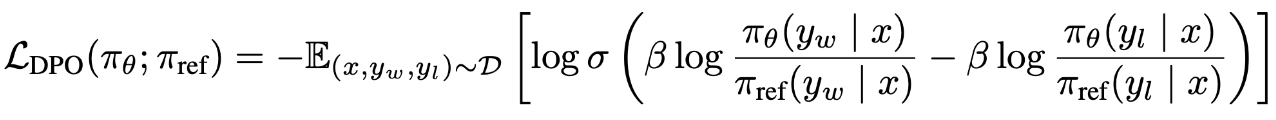

In [4]:
import torch
import torch.nn.functional as F


def get_log_prob(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    """Возвращает среднюю лог-ввероятность текста по всем токенам."""
    # logits: (batch_size, seq_len, vocab_size)
    # labels: (batch_size, seq_len)
    # returns (batch_size)

    # ваш код здесь
    return F.log_softmax(logits, dim=-1).gather(
        index=labels.unsqueeze(-1),
        dim=-1,
    ).squeeze(-1).mean(dim=-1)


In [5]:
get_log_prob(
    torch.Tensor([[[-2.7054,  0.0867,  0.1686,  0.1584],
         [-0.9548, -0.4562, -0.2700, -0.0865],
         [ 0.3822,  0.8500, -0.8196,  0.1957],
         [ 0.8570,  1.0611,  0.4546,  0.8677]],

        [[-0.2468, -1.3499, -0.0137,  1.0448],
         [-0.3271,  1.0209, -1.4851,  0.2751],
         [-0.0643, -0.3057,  1.4396,  0.2432],
         [-0.2092,  1.2529, -0.7603, -0.4862]]]),
      torch.LongTensor([[1, 1, 3, 0],
        [1, 1, 0, 2]])
      )

tensor([-1.3708, -2.0023])

### Тесты

In [6]:
assert torch.allclose(
  torch.Tensor([-1.3708, -2.0023]), get_log_prob(
    torch.Tensor([[[-2.7054,  0.0867,  0.1686,  0.1584],
         [-0.9548, -0.4562, -0.2700, -0.0865],
         [ 0.3822,  0.8500, -0.8196,  0.1957],
         [ 0.8570,  1.0611,  0.4546,  0.8677]],

        [[-0.2468, -1.3499, -0.0137,  1.0448],
         [-0.3271,  1.0209, -1.4851,  0.2751],
         [-0.0643, -0.3057,  1.4396,  0.2432],
         [-0.2092,  1.2529, -0.7603, -0.4862]]]),
      torch.LongTensor([[1, 1, 3, 0],
        [1, 1, 0, 2]])
      ),
    rtol=1e-4
)


assert torch.allclose(
  torch.Tensor([-1.4632]), get_log_prob(
    torch.Tensor([[[ 0.2743,  0.9203,  0.0347,  0.5378],
         [-0.1536, -0.2817, -0.7711,  0.0901],
         [ 2.0664,  0.8373,  1.3288,  1.2660],
         [-0.2940, -1.0327,  1.3188,  0.8796]]]),
      torch.LongTensor([[3, 1, 0, 0]])
      ),
    rtol=1e-4
)

In [7]:
def dpo_loss(
    model_chosen_logprob: torch.Tensor,
    model_rejected_logprob: torch.Tensor,
    ref_chosen_logprob: torch.Tensor,
    ref_rejected_logprob: torch.Tensor,
    beta: float = 0.1
):
    # должен вернуться tuple с 2 числами:
    # - dpo лосс по формуле выше
    # - accuracy того, что неявная награда модели для chosen выше, чем для rejected

    # ваш код здесь
    chosen_reward = model_chosen_logprob - ref_chosen_logprob
    rejected_reward = model_rejected_logprob - ref_rejected_logprob
    loss = calc_loss(
        chosen_reward=chosen_reward,
        rejected_reward=rejected_reward,
        beta=beta
    )
    accuracy = (chosen_reward > rejected_reward).float().mean()
    return loss, accuracy

In [10]:
actual_output = dpo_loss(
    torch.Tensor([-1.0]),
    torch.Tensor([-3.0]),
    torch.Tensor([-5.0]),
    torch.Tensor([-6.0]),
)

assert abs(actual_output[0].item() - 0.6444) < 1e-4
assert abs(actual_output[1].item() - 1.0) < 1e-4

In [ ]:
actual_output = dpo_loss(
    torch.Tensor([-12, -2]),
    torch.Tensor([-1, 4]),
    torch.Tensor([-5, 8]),
    torch.Tensor([-4, 2]),
)

assert abs(actual_output[0].item() - 1.3883) < 1e-4
assert abs(actual_output[1].item() - 0) < 1e-4

In [ ]:
actual_output = dpo_loss(
    torch.Tensor([-3, -1]),
    torch.Tensor([-4, -1]),
    torch.Tensor([-5, 8]),
    torch.Tensor([-4, 2]),
)

assert abs(actual_output[0].item() - 0.8178) < 1e-4
assert abs(actual_output[1].item() - 0.5) < 1e-4

# DPO - 10 баллов
Давайте обучим модель с помощью DPO. Для этого нам нужен датасет прфеернций - нам нужен некий префикс (задача) и хороший и плохие ответы.

В качесве примера возьмем простую модель - SmolLM от huggingface.

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
checkpoint = "HuggingFaceTB/SmolLM-360M-Instruct"

device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

messages = [{"role": "user", "content": "what is the weather like today"}]
prompt_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
print("PROMPT")
print(prompt_text)
inputs = tokenizer(prompt_text, return_tensors="pt")
for k, v in inputs.items():
    inputs[k] = v.to(device)

gens = model.generate(**inputs)
print("Generated answer")
print(tokenizer.decode(gens[0, inputs["input_ids"].size(1):].tolist()))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

PROMPT
<|im_start|>user
what is the weather like today<|im_end|>
<|im_start|>assistant

Generated answer
What a great question! Today's weather is a fascinating topic. Here's a summary of the current weather conditions:

**Temperature:**

* The temperature is currently around 22°


Как мы видим у модели есть свой prompt_format и работает она как обычный ассистент - доброжелательно отвечает пользователю на поставленный вопрос.

Представим, что наши пользователи имеют возможность регенерации сообщений в нашем приложении: если им не нравится ответ, они могут сгенерировать новый. Иногда мы даем пользователю два ответа и просим выбрать тот, который больше понравился. Такое можно зачастую встретить например у OpenAI.

Рассмотрим датасет `HumanLLMs/Human-Like-DPO-Dataset` - это датасет пар ответов, в котором предпочтительный (chosen) ответ более "человечный", то есть содержит в себе смайлики, легкомыслие, а менее предпочтительный (rejected) ответ.
Как вы помните датасеты для DPO именно так и строятся - есть некоторый промпт (возможно, история диалога из нескольких шагов) и 2 ответа, один из которых хороший, а другой - плохой.

In [13]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [16]:
import json
from datasets import load_dataset
from pprint import pprint
dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset")

pprint(dataset["train"][0])

{'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is "
           'it a funny cat or a ridiculous situation? Spill the beans! 🤣',
 'prompt': 'Oh, I just saw the best meme - have you seen it?',
 'rejected': "I'm an artificial intelligence language model, I don't have "
             'personal experiences or opinions. However, I can provide you '
             'with information on highly-rated and critically acclaimed films, '
             'as well as recommendations based on specific genres or themes. '
             'Would you like me to suggest some notable movies or discuss a '
             'particular genre of interest?'}


In [15]:
train_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset", split="train[:10%]")
eval_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset", split="train[10%:12%]")

pprint(eval_dataset[0])


{'chosen': "You know, I think I'm a little bit of both, to be honest! I love "
           "the energy and anonymity of a big city – there's always something "
           'going on, and you can find pretty much anything you need at any '
           'hour. But at the same time, I appreciate the charm and sense of '
           "community that comes with a small town. There's something really "
           'cozy about knowing your neighbors and being able to walk down Main '
           'Street and run into friends.\n'
           '\n'
           "That being said, if I'm being completely honest, I'm a bit of a "
           'sucker for a good mountain town. You know, the kind of place with '
           "a cute downtown area, surrounded by trails and mountains? That's "
           'my happy place! What about you, do you have a preference?',
 'prompt': 'Are you more of a city person or a small-town fan?',
 'rejected': "As a professional AI, I don't possess personal preferences or "
             

In [30]:
pprint(eval_dataset[1])

{'chosen': "You know, I've been meaning to catch up on some new releases, but "
           "I just haven't had the time 😅. I did binge-watch that new season "
           'of "Stranger Things" though, and oh man, it was so good! I loved '
           'seeing the gang back together again. Have you watched it? What did '
           "you think? 🎥 And by the way, do you have any recommendations? I'm "
           'always up for something new! 🤔',
 'prompt': 'Oh, have you seen any good movies or TV shows lately?',
 'rejected': "I'm afraid I don't have personal preferences or emotions, nor do "
             'I have the capacity to enjoy music or any other form of '
             'entertainment. My purpose is to provide accurate and informative '
             'responses to assist with inquiries and tasks. However, I can '
             'provide information on the effects of different music genres on '
             'mood and productivity if that would be helpful. Please let me '
             "know 

Представим, что наши аналитики прислали нам такие данные и мы хотим сделать нашу модель лучше. Мы можем напрямую произвести обучениа на хороших сэмплах, но мы попробуем подать на обучение более богатый сигнал: мы не только хотим максимизировать вероятность chosen текста, но и дополнительно хотим минимизировать вероятность rejected текста. Чтобы еще сильнее разделить примеры, давайте оставим только те, где в chosen есть смайлик, а в rejected его нет.

In [28]:
import re
emoji_pattern = re.compile(
    '['
    '\U0001F600-\U0001F64F'  # Emoticons
    '\U0001F300-\U0001F5FF'  # Symbols & Pictographs
    '\U0001F680-\U0001F6FF'  # Transport & Map Symbols
    '\U0001F700-\U0001F77F'  # Alchemical Symbols
    '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
    '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
    '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
    '\U0001FA00-\U0001FA6F'  # Chess Symbols
    '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
    '\U00002702-\U000027B0'  # Dingbats
    '\U000024C2-\U0001F251'  # Enclosed characters
    '\U0000200D'             # Zero Width Joiner
    '\U0001F1E0-\U0001F1FF'  # Flags
    ']+',
    re.UNICODE
)
sample = "I love 🍕 and 🚀 and 😂!"
bool(emoji_pattern.search(sample))

True

In [26]:
train_dataset

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 1088
})

In [36]:
import re
emoji_pattern = re.compile(
    '['
    '\U0001F600-\U0001F64F'  # Emoticons
    '\U0001F300-\U0001F5FF'  # Symbols & Pictographs
    '\U0001F680-\U0001F6FF'  # Transport & Map Symbols
    '\U0001F700-\U0001F77F'  # Alchemical Symbols
    '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
    '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
    '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
    '\U0001FA00-\U0001FA6F'  # Chess Symbols
    '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
    '\U00002702-\U000027B0'  # Dingbats
    '\U000024C2-\U0001F251'  # Enclosed characters
    '\U0000200D'             # Zero Width Joiner
    '\U0001F1E0-\U0001F1FF'  # Flags
    ']+',
    re.UNICODE
)

def find_emojis(sample):
    # ВАШ КОД ЗДЕСЬ
    return bool(emoji_pattern.search(sample["chosen"]))

train_dataset = train_dataset.filter(find_emojis)
assert len(train_dataset) == 1061


Filter:   0%|          | 0/1061 [00:00<?, ? examples/s]

Наш тренер DPOTrainer будет собирать примеры из полей prompt, chosen и rejected. Чтобы все корректно обрабатывалось, нам нужно применить chat_template к нашим примерам. Так как у нас довольно простой случай с диалогом из одного шага (одна пара вопрос-ответ), мы можем применить chat_template к prompt. Добавлять EOS токен в chosen/rejected не нужно, это делает за нас DPOTrainer

In [63]:
def apply_chat_template(sample, tokenizer):
    # ВАШ КОД ЗДЕСЬ
    return {
        'prompt': tokenizer.apply_chat_template([{'role': 'user', 'content': sample['prompt']}],
                                                tokenize=False,
                                                add_generation_prompt=True),
        'chosen': sample['chosen'],
        'rejected': sample['rejected']
        }

reference = """<|im_start|>user\nOh, I just saw the best meme - have you seen it?<|im_end|>\n<|im_start|>assistant\n"""
sample = train_dataset[0]
new_sample = apply_chat_template(sample, tokenizer)
assert new_sample["chosen"] == sample["chosen"]
assert new_sample["rejected"] == sample["rejected"]
assert new_sample["prompt"] == reference


Давайте применим препроцессинг к нашему датасету

In [64]:
from functools import partial
partial_template = partial(apply_chat_template, tokenizer=tokenizer)
train_dataset = train_dataset.map(partial_template)
eval_dataset = eval_dataset.map(partial_template)


Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Теперь нужно создать LoRA модель. Учить DPO можно и без нее, но как вы помните в формуле DPO учавствуют вероятности от референсной модели - мы не хотим, чтобы наша модель далеко уходила от референса.
Если учить все веса модели, то нам потребуется хранить референсную модель в памяти, а это еще гигабайты видеопамяти, которые нам очень нужны, т.к. каждый батч в DPO обучении в два раза больше обычных батчей, так как мы считаем выходы и по chosen и по rejected.
Есть несколько вариантов с этим бороться:
1. Предпосчитать все выходы референсной модели и подгружать эти выходы с жесткого диска. Этот вариант хороший, но в этот раз мы поступим интереснее.
2. Можно использовать LoRA - тогда, чтобы получить референсную модель, нам достаточно не применять LoRA слои, которые мы обучаем. Таким образом мы не дублируем референсную модель, т.к. она содержится в нашей базовой модели. Эту логику поддерживает DPOTrainer и в этой задаче мы воспользуемся именно таким подходом.

Для создания модели используйте метод [get_peft_model](https://huggingface.co/docs/peft/v0.14.0/en/package_reference/peft_model#peft.get_peft_model)

In [ ]:
from trl import DPOTrainer, DPOConfig
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=...,
    lora_alpha=...,
    target_modules="all-linear",
    bias="none",
    task_type="CAUSAL_LM",
)

# для чекпоинтинга
model.enable_input_require_grads()
peft_model = ...


Заполним аргументы для обучения. Рекомендую поставить эффективный батч сайз 16 (с помощью аккумуляции), обычный батч сайз 4, одну эпоху обучения. Для удобства давайте поставим агрессивный lr = 1e-3, но обычно он в 10 раз меньше

In [ ]:

training_args = DPOConfig(
    output_dir="checkpoint",
    bf16=True,
    gradient_checkpointing=...,
    per_device_train_batch_size=...,
    per_device_eval_batch_size=...,
    gradient_accumulation_steps=...,
    gradient_checkpointing_kwargs={'use_reentrant':False},
    num_train_epochs=1,
    dataset_num_proc=1,
    dataloader_num_workers=1,
    logging_steps=10,
    report_to="none",
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    eval_steps=20,
    eval_strategy="steps",
    learning_rate=...,
    beta=0.1,
)
trainer = DPOTrainer(
    model=peft_model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
)
trainer.train()


for i in range(10):
    gens = peft_model.generate(**inputs, do_sample=True, temperature=0.8)
    print("Generated answer")
    print(tokenizer.decode(gens[0, inputs["input_ids"].size(1):].tolist()))


Как видим, у нас получилась новая модель, которая активнее ставит смайлики. Давайте разберем, какие метрики нам доступны в рамках обучения:

* loss - dpo функция потерь
* logps/chosen - логвероятности chosen ответа. Чем они ближе к 0, тем вероятнее мы оцениваем этот ответ. Эта метрика должна расти и приближаться к 0
* logps/rejected - логвероятности rejected ответа. Чем они ближе к 0, тем вероятнее мы оцениваем этот ответ. Эта метрика должна падать и приближаться к -inf
* rewards/chosen - `self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device))` - логарифм отношения вероятностей chosen ответа нашей модели к референсной модели, метрика должна расти
* rewards/rejected - `self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device))` - логарифм отношения вероятностей chosrejectedета нашей модели к референсной модели, метрика должна падать
* rewards/margins - разница между logps/chosen и logps/rejected, показывает насколько вероятнее мы сгенерируем chosen ответ, чем rejected
* rewards/accuracies - доля сэмплов в батче, где chosen ответу мы ставим вероятность выше, чем rejected


LoRA можно замерджить в модель, после чего сохранить полный чекпоинт по желанию. Для этого нам нужен метод [merge_and_unload](https://huggingface.co/docs/peft/main/en/package_reference/lora#peft.LoraModel.merge_and_unload), после чего можно вызвать [save_pretrained](https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/feature_extractor#transformers.FeatureExtractionMixin.save_pretrained)


In [ ]:

# объединяем веса с LoRA
model = ...
# сохраняем модель
...